<H1> Nombre: Rafael</H1>
<H1> Apellido: Elberg</H1>
<H1> Número de alumno: 18640974</H1>

#Pregunta 1

In [1]:
!gdown --id '15Z0tkJW6NTdvi9q0G3vQDgRyniXzqEzG'

Downloading...
From: https://drive.google.com/uc?id=15Z0tkJW6NTdvi9q0G3vQDgRyniXzqEzG
To: /home/rafa/Desktop/AI/SugarFreeManatee-IIC2613-2021-1/Tareas/Tarea 4/diamonds.zip
100%|████████████████████████████████████████| 712k/712k [00:00<00:00, 18.5MB/s]


In [1]:
import pandas as pd
import tensorflow as tf
import tensorflow.compat.v1.keras.backend as K
print(tf.config.experimental.list_physical_devices('GPU'))
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
import pickle
import matplotlib.pyplot as plt

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
df = pd.read_csv('diamonds.csv')
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z,Usage
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,ToV
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,Test
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,ToV
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,ToV
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,ToV


In [3]:
print(df.isnull().sum(axis = 0))

Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
Usage         0
dtype: int64


In [4]:
(df == 0).sum(axis = 0)
# Hay varios casos donde las dimensiones son 0, debemos descartarlos.

Unnamed: 0     0
carat          0
cut            0
color          0
clarity        0
depth          0
table          0
price          0
x              8
y              7
z             20
Usage          0
dtype: int64

In [5]:
df = df[~(df == 0).any(axis=1)]
# https://stackoverflow.com/questions/27020312/drop-row-in-pandas-dataframe-if-any-value-in-the-row-equals-zero

for col in df.columns:
    print(col, df[col].nunique())

#Vemos las columnas con menos valores únicos pues son las columnas cualitativas    
for col in df.columns:
    if df[col].nunique() < 10:
        print(col, list(df[col].unique()))

Unnamed: 0 53920
carat 273
cut 5
color 7
clarity 8
depth 184
table 127
price 11597
x 553
y 550
z 374
Usage 2
cut ['Ideal', 'Premium', 'Good', 'Very Good', 'Fair']
color ['E', 'I', 'J', 'H', 'F', 'G', 'D']
clarity ['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF']
Usage ['ToV', 'Test']


In [6]:
VALUES = {
    "cut":['Ideal','Premium','Good','Very Good','Fair'],
    "color":['E','I','J','H','F','G','D'],
    "clarity":['SI2','SI1','VS1','VS2','VVS2','VVS1','I1','IF']
}
# Le asignamos un valor arbitrario a cada categoría de las columnas cualitativas según su indexación.
# Dividímos el valor en la cantidad de categorías para obtener un número entre 0 y 1, y que sea 
# más fácil de manejar.

def numeracion(col, value):
    lista = VALUES.get(col)
    if lista:
        return lista.index(value)
    else:
        return value
    

for col in df.columns:
    if df[col].nunique() < 10:
        df[col] = df[col].apply(lambda x: numeracion(col,x))
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z,Usage
0,1,0.23,0,0,0,61.5,55.0,326,3.95,3.98,2.43,ToV
1,2,0.21,1,0,1,59.8,61.0,326,3.89,3.84,2.31,Test
2,3,0.23,2,0,2,56.9,65.0,327,4.05,4.07,2.31,ToV
3,4,0.29,1,1,3,62.4,58.0,334,4.20,4.23,2.63,ToV
4,5,0.31,2,2,0,63.3,58.0,335,4.34,4.35,2.75,ToV


A continuación cambiarémos los valores de cada columna para que sean más útiles y fáciles de trabajar. En particular, para cada columna harémos lo siguiente:
* "Unnamed: 0": Borrar :P Esta columna no nos entrega información útil.
* "carat": Esta columna ya se encuentra en un formato útil, con lo que solo la normalizaremso para que tenga valores similares a las otras columnas.
* "cut, color, clarity": Todas estas columnas serán separadas en vectores binarions según su categoría, para que el modelo pueda diferenciar mejor entre ellos. Dado que son columnas cualitativas, tiene más sentido representar cada categoría como un vector binário de si la tupla pertenece a la categoría o no, y no tratarlos como valores ya que el punto medio entre dos categorías no existe realmente, mientras que si usamos solamente números nuestro modelo podría pensar que una tupla puede estar entre G y D, por ejemplo. (Hacemos uso de Representation transformation para convertirlos en datos más útiles y Feature selection al no usar los datos redundantes).
* "depth, table": Ambos valores representan una fracción entre un dato que se puede obtener de x,y,z y un dato que no conocemos (altura de un diamante y ancho de la tabla del diamante). Para evitar redundancias obtendremos estos valores desconocidos y los usarémos en vez de depth y table. (Usamos Feature construction para crear datos nuevos a partir de datos que ya teníamos.)
* "x,y,z": Con el objetivo de agrupar estos valores en uno solo y disminuir la dimensión de nuestra entrada sin perjudicar la cantidad de información pertinente al modelo, convertirémos estos datos en un volumen = x*y*z. (Usamos Feature Extraction para reducir la dimensión de nuestros datos.) 

#Pregunta 2

Para las columnas categóricas usamos la estrategia de [Representation transformation](https://cloud.google.com/architecture/data-preprocessing-for-ml-with-tf-transform-pt1), que consiste en usar encoddings o embeddings para transformar datos de un tipo a otro. En particular crearemos vectores binários como se explica arriba. 

In [7]:
# Las separamos en vectores binarios con to_categorical y creamos columnas nuevas
for col in df.columns:
    if df[col].nunique() < 10 and not col=="Usage":
        print(col, list(df[col].unique()))
        df[VALUES[col]] = to_categorical(df[col], df[col].nunique())
df.head()

cut [0, 1, 2, 3, 4]
color [0, 1, 2, 3, 4, 5, 6]
clarity [0, 1, 2, 3, 4, 5, 6, 7]


,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,...,G,D,SI2,SI1,VS1,VS2,VVS2,VVS1,I1,IF
0,1,0.23,0,0,0,61.5,55.0,326,3.95,3.98,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.21,1,0,1,59.8,61.0,326,3.89,3.84,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.23,2,0,2,56.9,65.0,327,4.05,4.07,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,4,0.29,1,1,3,62.4,58.0,334,4.20,4.23,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5,0.31,2,2,0,63.3,58.0,335,4.34,4.35,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[Feature extraction](https://cloud.google.com/architecture/data-preprocessing-for-ml-with-tf-transform-pt1) consiste en reducir el número de features en nuestra matriz X usando conocimiento previo de los datos. En este caso agrupamos X, Y y Z en volúmen para usar menos datos. 
    
[Feature construction](https://cloud.google.com/architecture/data-preprocessing-for-ml-with-tf-transform-pt1) consiste en recolectar datos nuevos a partir de relaciones conocidas entre los datos. Obtenemos la altura a partir del depth y el diámetro promedio de la faja, y obtenemos el ancho a partir de table y el diámetro promedio del diamante para eliminar redundancias entre estos datos y las medidas del diamante, y obtener datos que desconocíamos.

In [8]:
df["volume"] = df.x*df.y*df.z

df["height"] = (df.depth/100)*((2*df.z)/(df.y+df.x))

df["width"] = (df.depth/100)*((df.x+df.y+df.z)/3)

df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,...,SI1,VS1,VS2,VVS2,VVS1,I1,IF,volume,height,width
0,1,0.23,0,0,0,61.5,55.0,326,3.95,3.98,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.202030,0.376910,2.123800
1,2,0.21,1,0,1,59.8,61.0,326,3.89,3.84,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,34.505856,0.357408,2.001307
2,3,0.23,2,0,2,56.9,65.0,327,4.05,4.07,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,38.076885,0.323741,1.978223
3,4,0.29,1,1,3,62.4,58.0,334,4.20,4.23,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,46.724580,0.389352,2.300480
4,5,0.31,2,2,0,63.3,58.0,335,4.34,4.35,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.917250,0.400633,2.413840



[Feature selection](https://cloud.google.com/architecture/data-preprocessing-for-ml-with-tf-transform-pt1) consiste en seleccionar los datos que creemos que serán útiles y eliminar redundancias.Creamos nuestro x, soltamos X,Y,Z,Cut,Color,Clarity,table,depth pues son redundantes. Botamos price pues son las labels.

In [9]:
X = df.copy()
X = X.drop(["Unnamed: 0","x","y","z","cut","color","clarity"], axis = 1)
X.head()

,carat,depth,table,price,Usage,Ideal,Premium,Good,Very Good,Fair,...,SI1,VS1,VS2,VVS2,VVS1,I1,IF,volume,height,width
0,0.23,61.5,55.0,326,ToV,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.202030,0.376910,2.123800
1,0.21,59.8,61.0,326,Test,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,34.505856,0.357408,2.001307
2,0.23,56.9,65.0,327,ToV,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,38.076885,0.323741,1.978223
3,0.29,62.4,58.0,334,ToV,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,46.724580,0.389352,2.300480
4,0.31,63.3,58.0,335,ToV,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.917250,0.400633,2.413840


In [10]:
# Finalmente separamos y normalizamos los datos:

grouped = X.groupby('Usage')
print(grouped.size()[0]/(grouped.size()[0]+grouped.size()[1]))
# Vemos que test representa mas o menos un 10%. 
# Luego haremos la partición 10/90 para validación y entrenamiento


test = grouped.get_group('Test')
train = grouped.get_group('ToV')

y_test = test.price.values
y_train = train.price.values

# https://www.kite.com/python/answers/how-to-split-a-pandas-dataframe-into-specifically-sized-chunks-with-random-contents-in-python

x_test = test.copy().drop(["Usage", "price"], axis = 1)
x_train = train.copy().drop(["Usage", "price"], axis = 1)

x_test = (x_test-x_test.mean())/x_test.std()
x_train = (x_train-x_train.mean())/x_train.std()

print(y_test.shape)
print(y_train.shape)
print(x_test.shape)
print(x_train.shape)

0.09920252225519288
(5349,)
(48571,)
(5349, 26)
(48571, 26)


#Pregunta 3

Definimos una función que nos permite generar modelos según  parámetros introducidos

In [11]:
def make_model(input_shape, n_inicial, n_oculto, activ_func):
    model = Sequential()
    model.add(Dense(n_inicial, input_shape=input_shape, activation=activ_func))
    model.add(Dense(n_oculto, activation=activ_func))
    model.add(Dense(1))
    return model

 Por investigaciones me ha tocado trabajar con arquitecturas convolucoionales como DCGAN (Goodfellow et al., 2014), en las cuales es importante que la dimension de las datos sea una potencia de 2, puesto que la dimensionalidad de los datos aumenta o disminuye al doble en cada capa, para generalizar de pixeles a patrones, o generar pixeles a partir de patrones. Similar a la relación encoder decoder en una red VAE (Yang et al., 2017). Por esto he decidido usar los números de neuronas presentados. Primero se usa el número de carácteristicas y se divide en 2. Los otros valores son potencias arbitrarias de 2, siguiendo el ejemplo de las redes convolucionales.

In [12]:
n = [(26,13),(32,16),(32,32),(64,32),(16,8)]

actv = ["relu","tanh","sigmoid"]
mse = []
mae = []
best_mae = float("inf")
models = []
best_model = None 
best_history = None
best = None

# Entrenamos los modelos y guardamos el mejor según su loss en el set de validación una vez pasadas las 20 
#  epochs. Este número fue decidido observando la evolución de las métricas, viendo que convergían alrededor
#  de este valor.
for i, e in n:
    for func in actv:
        print(f'Modelo {i}:{e}:{func}')
        model = make_model((26,),i,e, activ_func = func)
        model.compile(loss="mse", optimizer='rmsprop', metrics=["mse","mae"])
        history = model.fit(x_train, y_train, epochs=20, batch_size=32, verbose=1,validation_split= 0.1)
#          Este evaluate nos evalúa el modelo según las métricas dadas en el ultimo epoch.
        mse.append(history.history["val_loss"][-1])
        mae.append(history.history["val_mae"][-1])
        models.append(f'Modelo {i}:{e}:{func}')
        if history.history["val_mae"][-1] < best_mae:
            best_model = (model, f'Modelo {i}:{e}:{func}')
            best_mae = history.history["val_mae"][-1]
            best = {"n_inicial":i, "n_oculto":e, "activ_func":func}
            best_history = history.history


Modelo 26:13:relu
Epoch 1/20
1367/1367 [==============================] - 4s 3ms/step - loss: 28015274.0000 - mse: 28015274.0000 - mae: 3665.8169 - val_loss: 2369421.0000 - val_mse: 2369421.0000 - val_mae: 1335.9280
Epoch 2/20
1367/1367 [==============================] - 4s 3ms/step - loss: 5474896.5000 - mse: 5474896.5000 - mae: 1429.5009 - val_loss: 742973.5625 - val_mse: 742973.5625 - val_mae: 564.1477
Epoch 3/20
1367/1367 [==============================] - 5s 3ms/step - loss: 1596085.6250 - mse: 1596085.6250 - mae: 674.6443 - val_loss: 661993.1250 - val_mse: 661993.1250 - val_mae: 491.1891
Epoch 4/20
1367/1367 [==============================] - 5s 3ms/step - loss: 1234992.2500 - mse: 1234992.2500 - mae: 589.2730 - val_loss: 659061.5625 - val_mse: 659061.5625 - val_mae: 482.4141
Epoch 5/20
1367/1367 [==============================] - 5s 4ms/step - loss: 1170915.7500 - mse: 1170915.7500 - mae: 557.1902 - val_loss: 634060.5625 - val_mse: 634060.5625 - val_mae: 458.8926
Epoch 6/20
1367

Epoch 3/20
1367/1367 [==============================] - 7s 5ms/step - loss: 33900848.0000 - mse: 33900848.0000 - mae: 4081.6604 - val_loss: 4858220.0000 - val_mse: 4858220.0000 - val_mae: 2127.8511
Epoch 4/20
1367/1367 [==============================] - 8s 5ms/step - loss: 33747424.0000 - mse: 33747424.0000 - mae: 4062.8447 - val_loss: 4778564.5000 - val_mse: 4778564.5000 - val_mae: 2109.0500
Epoch 5/20
1367/1367 [==============================] - 7s 5ms/step - loss: 33595056.0000 - mse: 33595056.0000 - mae: 4044.0408 - val_loss: 4699563.0000 - val_mse: 4699563.0000 - val_mae: 2090.2371
Epoch 6/20
1367/1367 [==============================] - 7s 5ms/step - loss: 33443462.0000 - mse: 33443462.0000 - mae: 4025.2205 - val_loss: 4621101.0000 - val_mse: 4621101.0000 - val_mae: 2071.3833
Epoch 7/20
1367/1367 [==============================] - 7s 5ms/step - loss: 33291944.0000 - mse: 33291944.0000 - mae: 4006.3911 - val_loss: 4543679.0000 - val_mse: 4543679.0000 - val_mae: 2052.6099
Epoch 8/20

Epoch 5/20
1367/1367 [==============================] - 7s 5ms/step - loss: 33425070.0000 - mse: 33425070.0000 - mae: 4022.9387 - val_loss: 4603404.5000 - val_mse: 4603404.5000 - val_mae: 2067.1091
Epoch 6/20
1367/1367 [==============================] - 7s 5ms/step - loss: 33241752.0000 - mse: 33241752.0000 - mae: 4000.1182 - val_loss: 4509544.0000 - val_mse: 4509544.0000 - val_mae: 2044.2787
Epoch 7/20
1367/1367 [==============================] - 7s 5ms/step - loss: 33059358.0000 - mse: 33059358.0000 - mae: 3977.2783 - val_loss: 4416805.5000 - val_mse: 4416805.5000 - val_mae: 2021.4670
Epoch 8/20
1367/1367 [==============================] - 6s 5ms/step - loss: 32878938.0000 - mse: 32878938.0000 - mae: 3954.4487 - val_loss: 4324945.5000 - val_mse: 4324945.5000 - val_mae: 1998.6196
Epoch 9/20
1367/1367 [==============================] - 7s 5ms/step - loss: 32698856.0000 - mse: 32698856.0000 - mae: 3931.6245 - val_loss: 4234421.5000 - val_mse: 4234421.5000 - val_mae: 1975.8416
Epoch 10/2

Epoch 8/20
1367/1367 [==============================] - 7s 5ms/step - loss: 31658804.0000 - mse: 31658804.0000 - mae: 3797.0903 - val_loss: 3681436.7500 - val_mse: 3681436.7500 - val_mae: 1830.5630
Epoch 9/20
1367/1367 [==============================] - 6s 5ms/step - loss: 31323740.0000 - mse: 31323740.0000 - mae: 3752.8914 - val_loss: 3521334.7500 - val_mse: 3521334.7500 - val_mae: 1786.2987
Epoch 10/20
1367/1367 [==============================] - 6s 4ms/step - loss: 30995244.0000 - mse: 30995244.0000 - mae: 3709.0828 - val_loss: 3365177.7500 - val_mse: 3365177.7500 - val_mae: 1742.5216
Epoch 11/20
1367/1367 [==============================] - 6s 4ms/step - loss: 30668848.0000 - mse: 30668848.0000 - mae: 3666.2258 - val_loss: 3213291.2500 - val_mse: 3213291.2500 - val_mae: 1698.8755
Epoch 12/20
1367/1367 [==============================] - 7s 5ms/step - loss: 30346510.0000 - mse: 30346510.0000 - mae: 3624.6707 - val_loss: 3065150.7500 - val_mse: 3065150.7500 - val_mae: 1655.1824
Epoch 1

Epoch 10/20
1367/1367 [==============================] - 6s 5ms/step - loss: 30941624.0000 - mse: 30941624.0000 - mae: 3701.9460 - val_loss: 3339805.0000 - val_mse: 3339805.0000 - val_mae: 1735.3069
Epoch 11/20
1367/1367 [==============================] - 6s 4ms/step - loss: 30616230.0000 - mse: 30616230.0000 - mae: 3659.3149 - val_loss: 3188989.5000 - val_mse: 3188989.5000 - val_mae: 1691.7863
Epoch 12/20
1367/1367 [==============================] - 6s 4ms/step - loss: 30296562.0000 - mse: 30296562.0000 - mae: 3618.1123 - val_loss: 3041749.7500 - val_mse: 3041749.7500 - val_mae: 1648.1860
Epoch 13/20
1367/1367 [==============================] - 6s 5ms/step - loss: 29978070.0000 - mse: 29978070.0000 - mae: 3578.2144 - val_loss: 2898192.2500 - val_mse: 2898192.2500 - val_mae: 1611.1471
Epoch 14/20
1367/1367 [==============================] - 7s 5ms/step - loss: 29664830.0000 - mse: 29664830.0000 - mae: 3539.7854 - val_loss: 2758471.0000 - val_mse: 2758471.0000 - val_mae: 1575.4032
Epoch

1367/1367 [==============================] - 6s 4ms/step - loss: 33173968.0000 - mse: 33173968.0000 - mae: 3991.6240 - val_loss: 4496900.0000 - val_mse: 4496900.0000 - val_mae: 2041.1847
Epoch 13/20
1367/1367 [==============================] - 5s 3ms/step - loss: 33077820.0000 - mse: 33077820.0000 - mae: 3979.5305 - val_loss: 4447631.0000 - val_mse: 4447631.0000 - val_mae: 2029.0784
Epoch 14/20
1367/1367 [==============================] - 6s 5ms/step - loss: 32981740.0000 - mse: 32981740.0000 - mae: 3967.4714 - val_loss: 4398819.0000 - val_mse: 4398819.0000 - val_mae: 2017.0153
Epoch 15/20
1367/1367 [==============================] - 6s 4ms/step - loss: 32886242.0000 - mse: 32886242.0000 - mae: 3955.4084 - val_loss: 4350395.0000 - val_mse: 4350395.0000 - val_mae: 2004.9763
Epoch 16/20
1367/1367 [==============================] - 6s 4ms/step - loss: 32790978.0000 - mse: 32790978.0000 - mae: 3943.3237 - val_loss: 4302123.5000 - val_mse: 4302123.5000 - val_mae: 1992.9026
Epoch 17/20
1367/

In [13]:
dict_mae = {"model":models, "mae": mae}
df_mae = pd.DataFrame(data = dict_mae)
pd.set_option('display.max_rows', 15)
display(df_mae)
dict_mse = {"model":models, "mse": mse}
df_mse = pd.DataFrame(data = dict_mse)
display(df_mse)
print(f'Mejor modelo: {best_model[1]}')

,model,mae
0,Modelo 26:13:relu,212.582581
1,Modelo 26:13:tanh,1803.673096
2,Modelo 26:13:sigmoid,1808.399780
3,Modelo 32:16:relu,210.208649
4,Modelo 32:16:tanh,1725.799927
5,Modelo 32:16:sigmoid,1730.568604
6,Modelo 32:32:relu,211.080429
7,Modelo 32:32:tanh,1344.234985
8,Modelo 32:32:sigmoid,1367.892212
9,Modelo 64:32:relu,200.793518


,model,mse
0,Modelo 26:13:relu,4.960018e+05
1,Modelo 26:13:tanh,3.583712e+06
2,Modelo 26:13:sigmoid,3.600774e+06
3,Modelo 32:16:relu,4.750784e+05
4,Modelo 32:16:tanh,3.306541e+06
5,Modelo 32:16:sigmoid,3.323199e+06
6,Modelo 32:32:relu,5.003524e+05
7,Modelo 32:32:tanh,1.994240e+06
8,Modelo 32:32:sigmoid,2.024533e+06
9,Modelo 64:32:relu,4.936711e+05


Mejor modelo: Modelo 64:32:relu


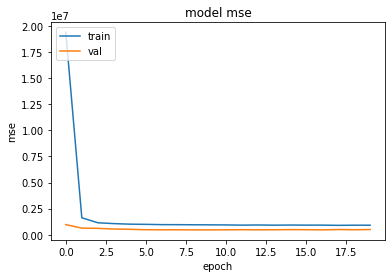

In [14]:
plt.plot(best_history['mse'])
plt.plot(best_history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

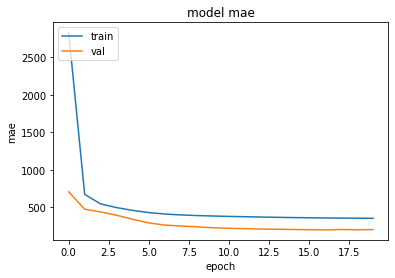

In [15]:
plt.plot(best_history['mae'])
plt.plot(best_history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
print(best_model[1])
best_model[0].summary()

Modelo 64:32:relu
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 64)                1728      
_________________________________________________________________
dense_28 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 33        
Total params: 3,841
Trainable params: 3,841
Non-trainable params: 0
_________________________________________________________________


In [17]:
test_results = best_model[0].evaluate(x_test, y_test, verbose=1)

168/168 [==============================] - 0s 1ms/step - loss: 418966.7188 - mse: 418966.7188 - mae: 332.9020


Vemos que el valor de mse y mae es mayor en el set de entrenamiento que en el set de validación, y mayor en el set de testeo que en el de entrenamiento. Es decir, su mejor rendimiento fue en el set de validación.

#Pregunta 4

Defino una función que pueda agregar capas que recibe en forma de lista.

In [18]:
def make_deep_model(input_shape = (26,), n_inicial = 9, n_oculto = 4, activ_func = "relu", layers = []):
    model = Sequential()
    model.add(Dense(n_inicial, input_shape=input_shape, activation=activ_func))
    model.add(Dense(n_oculto, activation=activ_func))
    for lay in layers:
        model.add(Dense(lay, activation=activ_func))
    
    model.add(Dense(1))
    return model

Los números de las capas también son relativamente arbitrareos, aunque nuevamente prefiero potencias de 2 con dimensiones descendientes, o múltiplos de la dimensión de entrada. 

In [25]:
layers = [[26,13,7],[32,16,8],[8,6,4],[32,32],[16],[16,8,4]]
mse1 = []
mae1 = []
best_mae1 = float("inf")
models1 = []
best_model1 = None
best1 = best.copy()
best_history1 = None
for layer in layers:
        print(f'Modelo {str(layer)}')
        model = make_deep_model(input_shape = (26,), **best, layers = layer)
        model.compile(loss="mse", optimizer='rmsprop', metrics=["mse","mae"])
        history = model.fit(x_train, y_train, epochs=15, batch_size=32, verbose=1,validation_split= 0.1)
        mse1.append(history.history["val_loss"][-1])
        mae1.append(history.history["val_mae"][-1])
        models1.append(f'Modelo {str(layer)}')
        if history.history["val_mae"][-1] < best_mae1:
            best_model1 = (model, f'Modelo {str(layer)}')
            best_mae1 = history.history["val_mae"][-1]
            best1["layers"] = layer


Modelo [26, 13, 7]
Epoch 1/15
1367/1367 [==============================] - 8s 6ms/step - loss: 12215472.0000 - mse: 12215472.0000 - mae: 1830.0186 - val_loss: 598135.7500 - val_mse: 598135.7500 - val_mae: 431.9502
Epoch 2/15
1367/1367 [==============================] - 9s 6ms/step - loss: 1145016.8750 - mse: 1145016.8750 - mae: 477.8831 - val_loss: 476436.6562 - val_mse: 476436.6562 - val_mae: 311.9492
Epoch 3/15
1367/1367 [==============================] - 9s 6ms/step - loss: 1062687.2500 - mse: 1062687.2500 - mae: 416.3162 - val_loss: 498048.0000 - val_mse: 498048.0000 - val_mae: 256.0797
Epoch 4/15
1367/1367 [==============================] - 10s 7ms/step - loss: 1034992.1875 - mse: 1034992.1875 - mae: 395.5054 - val_loss: 462763.1562 - val_mse: 462763.1562 - val_mae: 223.4461
Epoch 5/15
1367/1367 [==============================] - 9s 7ms/step - loss: 996586.1250 - mse: 996586.1250 - mae: 382.0991 - val_loss: 473599.9062 - val_mse: 473599.9062 - val_mae: 225.3122
Epoch 6/15
1367/136

Epoch 11/15
1367/1367 [==============================] - 10s 7ms/step - loss: 881079.0625 - mse: 881079.0625 - mae: 347.6701 - val_loss: 421383.8438 - val_mse: 421383.8438 - val_mae: 203.5995
Epoch 12/15
1367/1367 [==============================] - 8s 6ms/step - loss: 851818.1875 - mse: 851818.1875 - mae: 346.4907 - val_loss: 421121.6875 - val_mse: 421121.6875 - val_mae: 199.5037
Epoch 13/15
1367/1367 [==============================] - 10s 8ms/step - loss: 811666.9375 - mse: 811666.9375 - mae: 345.4518 - val_loss: 411801.1250 - val_mse: 411801.1250 - val_mae: 205.4178
Epoch 14/15
1367/1367 [==============================] - 10s 8ms/step - loss: 794257.8125 - mse: 794257.8125 - mae: 343.4082 - val_loss: 389491.2500 - val_mse: 389491.2500 - val_mae: 198.2890
Epoch 15/15
1367/1367 [==============================] - 11s 8ms/step - loss: 802323.0625 - mse: 802323.0625 - mae: 342.3154 - val_loss: 413184.8125 - val_mse: 413184.8125 - val_mae: 205.8406


In [26]:
print(best1)

{'n_inicial': 64, 'n_oculto': 32, 'activ_func': 'relu', 'layers': [16]}


El mejor modelo tiene la forma 64->32->16

In [27]:
dict_mae1 = {"model":models1, "mae": mae1}
df_mae1 = pd.DataFrame(data = dict_mae1)
display(df_mae1)
dict_mse1 = {"model":models1, "mse": mse1}
df_mse1 = pd.DataFrame(data = dict_mse1)
display(df_mse1)

,model,mae
0,"Modelo [26, 13, 7]",195.866531
1,"Modelo [32, 16, 8]",225.373169
2,"Modelo [8, 6, 4]",197.380219
3,"Modelo [32, 32]",205.665894
4,Modelo [16],192.844452
5,"Modelo [16, 8, 4]",205.840622


,model,mse
0,"Modelo [26, 13, 7]",445653.93750
1,"Modelo [32, 16, 8]",380160.96875
2,"Modelo [8, 6, 4]",466529.34375
3,"Modelo [32, 32]",373921.87500
4,Modelo [16],466129.37500
5,"Modelo [16, 8, 4]",413184.81250


#AR - demo

In [28]:
#Descarga del ambiente (RUN ME!)
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip3 install box2d-py

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 819 kB 6.3 MB/s eta 0:00:01
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.2.0
    Uninstalling setuptools-57.2.0:
^C
ERROR: Operation cancelled by user
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [29]:
#@title Importes (RUN ME TOO!)
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

In [30]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

Vamos a inicializar el ambiente

In [31]:
env = gym.make('CartPole-v1')

Cada vez que se resetea el ambiente se envía una observación del estado en el que inicia la nueva instancia.

In [32]:
obs = env.reset()
print(obs)

[-0.00696772 -0.04490292 -0.00065385 -0.03861673]


Estos son los estados de ciertas variables importantes, para el ambiente. En ese caso estamos utilizando el ambiente ```CartPole-v1```. Según la [wiki](https://github.com/openai/gym/wiki/CartPole-v0) del toolkit las observaciones del sistema son: <p>

>Num | Observations | Min | Max
>--- | --- | ---  | ---
>0 | Cart Position | -2.4 | 2.4
>1 | Cart Velocity | -Inf | Inf
>2 | Pole Angle | ~-41.8° | ~41.8°
>3 | Pole Velocity at tip | -Inf | Inf


In [33]:
print('Su espacio de acciones es', env.action_space)

Su espacio de acciones es Discrete(2)


En pocas palabras

>Num | Action
>--- | --- 
>0 | Push car to left
>1 | Push car to right

Cada vez que se carga el ambiente se inicializa en algún estado aleatorio, con el péndulo en posición vertical. Veamos dos ejemplos.

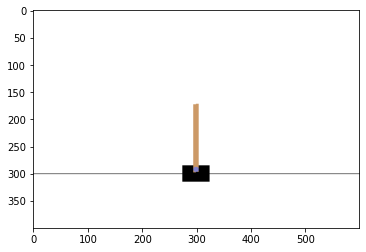

In [34]:
import matplotlib.pyplot as plt
plt.imshow(env.render(mode='rgb_array'));

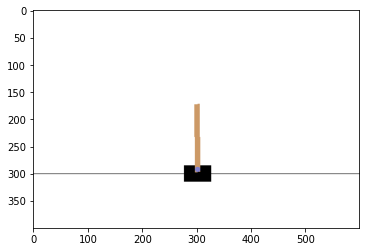

In [35]:
env.reset()
plt.imshow(env.render(mode='rgb_array'));

La diferencia es sutil, esto pues este ambiente tiene un desafío como diseño. Hay que mantener el péndulo vertical tanto como se pueda. Luego de eso el ambiente termina. <br>
Ambientes como éste se denominan episódicos. Y tienden a funcionar en series de episodios. Muchos juegos caen en esta categoría, juegos de atari como pacman, o incluso juegos analógicos como el ajedrés también son episódicos.<br>
Los episodios de este ambiente terminan si:


*   El ángulo del péndulo es mayor a $\pm 12°$
*   La posición del carro es mayor a $\pm 2.4$
*   El largo del episodio es mayor a 500



Cada ambiente puede enviar una secuencia de acciones aleatorias si se le desea.

In [36]:
[env.action_space.sample() for _ in range(10)]

[0, 0, 1, 1, 0, 0, 1, 1, 1, 0]

Calculemos cuantas acciones de "ir a la izquierda" puede tomar en promedio el sistema antes de que termine el episodio.

In [37]:
def actions_till_done(env, action):
    env.reset()
    done = False
    count = 0
    while done == False:
        _, _, done, _, = env.step(action)
        count += 1
    return count
  
# Get an estimate for how many 0 actions you can take on average before the 
# pole falls over
np.mean([actions_till_done(env, 0) for _ in range(100)])

9.37

De la misma manera se puede definir un criterio que calcule la cantidad de recompensas que se pueden obtener por episodio en promedio.

In [38]:
def average_episodic_return(env, agent, episodes=10, max_steps_per_episode=500):
    episode_rewards = []
    for episode in range(episodes):
        total_rewards = 0
        obs = env.reset()
        for t in range(max_steps_per_episode):
            out = agent(obs) # we don't care about the probabilities here
            assert ("Action" in out), "The key 'Action' was missing from the agents output."
            obs, rew, done, _ = env.step(out["Action"])
            total_rewards += rew
            # check if we are done, if so, exit loop
            if done:
                break
                
        episode_rewards.append(total_rewards)
        
    return {
        "AverageEpisodicReturn": np.mean(episode_rewards), 
        "StandardDeviation":np.sqrt(np.var(episode_rewards))
    }

In [39]:
def agent_left(observation):
    return {"Action":0}

In [40]:
average_episodic_return(env, agent_left)

{'AverageEpisodicReturn': 9.5, 'StandardDeviation': 0.6708203932499369}

De la misma forma que pudimos mostrar una imagen de un estado del agente se puede presentar al agente en una secuencia animada.

In [41]:
from collections import deque
import matplotlib.animation
import matplotlib.pyplot as plt
%matplotlib inline

def animate_agent(env, agent, max_steps = 400):
    obs = env.reset()
    frames = deque()
    frames.append(env.render(mode='rgb_array'))
    for _ in range(max_steps):
        out = agent(obs)
        assert ("Action" in out), "The key 'Action' was missing from the agents output."
        action = out["Action"]
        obs, _ , done, _ = env.step(action)
        frames.append(env.render(mode='rgb_array'))
        if done:
            break
            
    return animate_frames(frames)

def animate_frames(frames):
    new_height = 2.2
    original_height = frames[0].shape[0]
    original_width = frames[0].shape[1]
    new_width = (new_height / original_height) * original_width
    fig = plt.figure(figsize=(new_width, new_height), dpi = 120)
    
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    patch = ax.imshow(frames[0], aspect='auto', animated=True, interpolation='bilinear')
    animate = lambda i: patch.set_data(frames[i])
    
    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(frames), interval = 50)
    
    plt.close()
    return HTML(ani.to_jshtml())

¿Cómo se ve el agente cuando se le da la orden de ir siempre a la izquierda?

In [42]:
def agent_left(observation):
    return {"Action":0}
  
animate_agent(env, agent_left, max_steps = 400)

¿Y si se envía una orden aleatoria para que se mueva a izquierda o derecha?

In [43]:
def agent_random(observation):
    return {"Action":np.random.choice([0, 1])}

In [44]:
average_episodic_return(env, agent_random)

{'AverageEpisodicReturn': 19.3, 'StandardDeviation': 5.9}

In [45]:
animate_agent(env, agent_random)

Podemos definir una función que discretice el valor del estado en caso de que necesitasemos un valor en este dominio.

In [46]:
def state_for(observation):
    ranges = [np.arange(-1, 1.25, 0.25), np.arange(-0.3, 0.375, 0.075)[:9], np.arange(-1, 1.25, 0.25)]
    state = np.zeros((3,)) #Ignorando el primer sensor
    for i, (obs, limits) in enumerate(zip(observation[1:], ranges)):
        if obs < limits[0]:
            state[i] = 0
            continue
        for j in range(1, len(limits) - 1):
            if limits[j] <= obs <= limits[j+1]:
                state[i] = j
                break
        if obs > limits[len(limits) - 1]:  
            state[i] = len(limits)

    currstate = 0

    for i in range(3): 
        currstate += state[i] * (10 ** i)
    print(state)
    return int(currstate)


Este es un ejemplo del carro cuando ha sido entrenado correctamente un agente utilizando q learning.

In [19]:
animate_agent(env, agent)

NameError: name 'agent' is not defined

In [20]:
average_episodic_return(env, agent)

NameError: name 'agent' is not defined

#Pregunta 5

Creamos el environment y verificamos que el espacio de observación y acción corresponde al esperado.

In [49]:
env = gym.make('Pendulum-v0')

In [50]:
obs = env.reset()
print(obs)
env.render()

print('Su espacio de acciones es', env.action_space)
print('Su espacio de observación es', env.observation_space)

[0.94363882 0.33097701 0.94015158]
Su espacio de acciones es Box(-2.0, 2.0, (1,), float32)
Su espacio de observación es Box(-8.0, 8.0, (3,), float32)


A continuación se muestra el espacio de observaciones y acciones según la [wiki](https://github.com/openai/gym/wiki/Pendulum-v0)

## Observations
Type: Box(3)

Num | Observation  | Min | Max  
----|--------------|-----|----   
0   | cos(theta)   | -1.0| 1.0
1   | sin(theta)   | -1.0| 1.0
2   | theta dot    | -8.0| 8.0




## Actions

Type: Box(1)

Num | Action  | Min | Max  
----|--------------|-----|----   
0   | Joint effort | -2.0| 2.0


Generamos 1000 observaciones para determinar los rangos y creamos histogramas con estos datos.

In [51]:
observations = pd.DataFrame([env.observation_space.sample() for _ in range(1000)],\
                            columns = ["cos_theta", "sin_theta", "theta dot"])

observations.head()

,cos_theta,sin_theta,theta dot
0,-0.902648,0.245070,1.341330
1,-0.409350,0.778574,7.287824
2,-0.975180,0.078854,-7.507980
3,0.671759,-0.802262,3.267576
4,-0.367414,0.072819,-4.475534


array([[<AxesSubplot:title={'center':'cos_theta'}>,
        <AxesSubplot:title={'center':'sin_theta'}>],
       [<AxesSubplot:title={'center':'theta dot'}>, <AxesSubplot:>]],
      dtype=object)

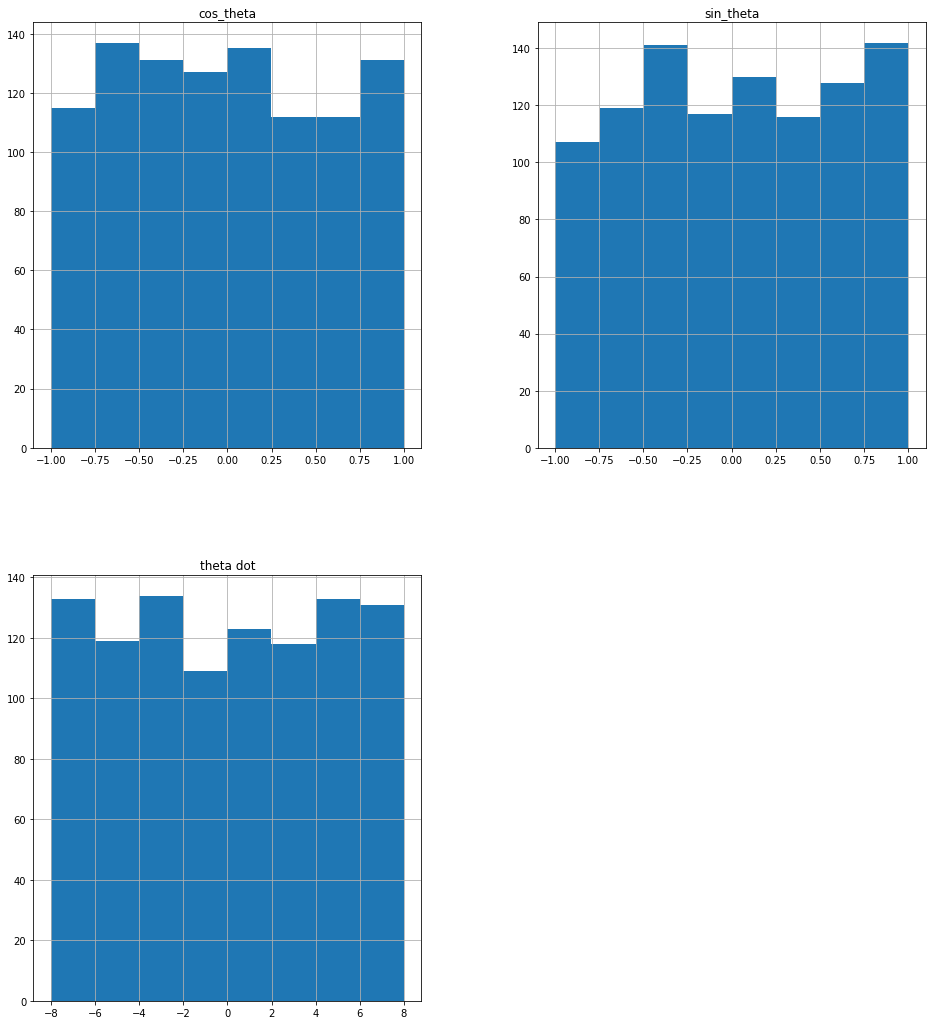

In [52]:
import matplotlib.pyplot as plt

plt.figsize =10
observations.hist(bins=8, figsize = (16,18), grid = True)

In [53]:
def state_for(observation):
    
    # Definímos un rango apto para cada sensor, tal que hayan 8 intervalos.
    ranges = [np.arange(-1, 1.25, 0.25), np.arange(-1, 1.25, 0.25), np.arange(-8, 10, 2)]
    state = np.zeros((3,)) # No ignoramos el primer sensor :P 
    for i, (obs, limits) in enumerate(zip(observation, ranges)):
        if obs < limits[0]:
            state[i] = 0
            continue
        for j in range(1, len(limits) - 1):
            if limits[j] <= obs <= limits[j+1]:
                state[i] = j
                break
        if obs > limits[len(limits) - 1]:  
            state[i] = len(limits)

    currstate = 0

    for i in range(3): 
        currstate += state[i] * (10 ** i)
#   Codificámos en base 10. 

#     Retornamos un número cuyas unidades son la discretización de cos_theta,
#     sus decenas de sin theta, y sus centenas de theta dot.
    return int(currstate)

#  Cantidad de estados posibles : 8*8*8 = 512

In [54]:
obs = env.reset()
print(obs)
print(state_for(obs))

[-0.97023472 -0.24216644 -0.62147766]
330


In [98]:
def action_for(index_n):
#     Definímos un rango apto para las acciónes, siendo que se puede tomar solo una
#     y varía entre -2 y 2. En este caso creamos 10 intervalos.
    index = np.arange(0, 11, 1)
    ranges = [np.arange(-2, 2.4, 0.4)]
    state = 0
    for i, (obs, limits) in enumerate(zip(index_n, ranges)):
        if obs < index[0]:
            state = round(limits[0], 2)
            continue
        for j in range(0, len(index) - 1):
            if index[j] <= obs <= index[j+1]:
                state = round(limits[j], 2)
                break
        if obs > index[len(index) - 1]:  
            state = round(limits[-1], 2)

    #   Asignamos un número entre -2 y 2 para cualquier indice en [0,10] 
    return (state)

In [99]:
action_for([4])

-0.8

#Pregunta 6

In [96]:
def agente(observation):
    obs = env.reset()
    return {"Action" :[action_for([random.randint(0,10)])]}
    

In [94]:
Q_matrix = np.array([[]])
print(Q_matrix)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [100]:
animate_agent(env, agente)

In [101]:
average_episodic_return(env, agente)

{'AverageEpisodicReturn': -1665.4213840395046,
 'StandardDeviation': 41.74611042842351}

#Pregunta 7 (BONO)

### Bibliografía:

Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., Courville, A., & Bengio, Y. (2014). Generative adversarial networks. Communications of the ACM, 63(11), 139–144. https://doi.org/10.1145/3422622


Yang, J., Thomas, M. S. C., & Liu, H. (2017). Rule extraction from autoencoder-based connectionist computational models. Concurrency and Computation: Practice and Experience, 31(3), e4262. https://doi.org/10.1002/cpe.4262